In [38]:
import numpy as np
import itertools
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib import transforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import dask
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import pandas as pd
import netCDF4

In [39]:
def plot_generator_paper(sample, X, Z):
    
    fz = 15*1.25
    lw = 4
    siz = 100
    XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
    XTEXT = 0.25 # Text placement
    YTEXT = 0.3 # Text placement
    
    plt.rc('text', usetex=False)
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    #mpl.rcParams["font.serif"] = "STIX"
    plt.rc('font', family='serif', size=fz)
    matplotlib.rcParams['lines.linewidth'] = lw
    
    
    cmap="RdBu_r"
    fig, ax = plt.subplots(1,1, figsize=(15,6))
    cs0 = ax.pcolor(X, Z, sample, cmap=cmap)
    ax.set_title("Anomalous Vertical Velocity Field Detected By ELBO")
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xlabel("CRMs", fontsize=fz*1.5)
    ax.xaxis.set_label_coords(0.54,-0.05)
    h = ax.set_ylabel("hPa", fontsize = fz*1.5)
    h.set_rotation(0)
    ax.yaxis.set_label_coords(-0.10,0.44)
    #y_ticks = np.arange(1350, 0, -350)
    #ax.set_yticklabels(y_ticks, fontsize=fz*1.33)
    ax.tick_params(axis='x', labelsize=fz*1.33)
    ax.tick_params(axis='y', labelsize=fz*1.33)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(cs0, cax=cax)
    cbar.set_label(label=r'$\left(\mathrm{m\ s^{-1}}\right)$', rotation="horizontal", fontsize=fz*1.5, labelpad=30, y = 0.65)
    plt.savefig("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/CI_Figure_Data/Anomaly.pdf")
    
#plot_generator(test[0,:,:])

In [40]:
def slerp(count, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    values = np.linspace(0, 1, num=count)
    output_array = np.empty(shape=(count,low.size))
    for i in range(len(values)):
        val = values[i]
        omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
        so = np.sin(omega)
        output_array[i,:] = np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high
    return output_array


def slerp(val, low, high):
    """Spherical interpolation. val has a range of 0 to 1."""
    if val <= 0:
        return low
    elif val >= 1:
        return high
    elif np.allclose(low, high):
        return low
    omega = np.arccos(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega)/so * high

In [41]:
z_test_tsne = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Synoptic_Latent_Spaces/2D_PCA_Latent_Space__31.npy")
#z_test_tsne = z_test_tsne[:int(912384/10),:]
Test_Images = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_W_Test.npy")
Max_Scalar = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_Max_Scalar.npy")
Min_Scalar = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_Min_Scalar.npy")
Test_Images = np.interp(Test_Images, (0, 1), (Min_Scalar, Max_Scalar))

In [42]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
levs = np.array(others.variables['lev'])
new = np.flip(levs)
crms = np.arange(1,129,1)
Xs, Zs = np.meshgrid(crms, new)

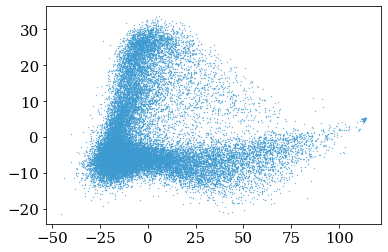

In [43]:
plt.scatter(x=z_test_tsne[:, 0], y=z_test_tsne[:, 1], c="#3D9AD1", s=0.1)
plt.show()

In [44]:
horz_line = np.squeeze(np.argwhere(np.logical_and(z_test_tsne[:,1] > -8.1, z_test_tsne[:,1] < -7.9)))
vert_line = np.squeeze(np.argwhere(np.logical_and(z_test_tsne[:,0] > -12.1, z_test_tsne[:,0] < -11.9)))

In [45]:
horz_line_images = Test_Images[horz_line,:,:]
horz_line_latent = z_test_tsne[horz_line,:]

vert_line_images = Test_Images[vert_line,:,:]
vert_line_latent = z_test_tsne[vert_line,:]

horz_line_images_sorted = np.empty(horz_line_images.shape)
horz_line_latent_sorted = np.empty(horz_line_latent.shape)
vert_line_images_sorted = np.empty(vert_line_images.shape)
vert_line_latent_sorted = np.empty(vert_line_latent.shape)

In [46]:
count = 0
for i in range(len(horz_line_images_sorted)):
    ind = np.nanargmin(horz_line_latent[:,0])
    horz_line_images_sorted[count,:] = horz_line_images[ind,:]
    horz_line_latent_sorted[count,:] = horz_line_latent[ind,:]
    horz_line_latent[ind,:] = np.array([1000.0,1000.0])
    #horz_line_images[ind,:] = np.array([1000.0,1000.0])
    count = count+1
    
count = 0
for i in range(len(vert_line_images_sorted)):
    ind = np.nanargmin(vert_line_latent[:,1])
    vert_line_images_sorted[count,:] = vert_line_images[ind,:]
    vert_line_latent_sorted[count,:] = vert_line_latent[ind,:]
    vert_line_latent[ind,:] = np.array([10000.0,10000.0])
    #vert_line_image[ind,:] = np.array([1000.0,1000.0])
    count = count+1

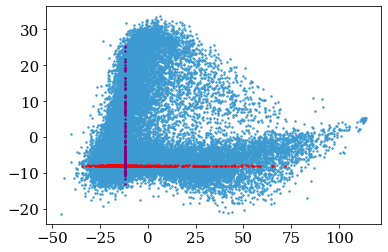

In [47]:
plt.scatter(x=z_test_tsne[:, 0], y=z_test_tsne[:, 1], c="#3D9AD1", s=2.0)
plt.scatter(x=horz_line_latent_sorted[:, 0], y=horz_line_latent_sorted[:, 1], c="Red", s=2.0)
plt.scatter(x=vert_line_latent_sorted[:, 0], y=vert_line_latent_sorted[:, 1], c="Purple", s=2.0)
plt.show()

In [48]:
print(np.where(z_test_tsne == horz_line_latent_sorted[0]))
print(np.where(z_test_tsne == horz_line_latent_sorted[-1]))
print(np.where(z_test_tsne == vert_line_latent_sorted[0]))
print(np.where(z_test_tsne == vert_line_latent_sorted[-1]))

(array([2425, 2425]), array([0, 1]))
(array([7803, 7803]), array([0, 1]))
(array([20826, 20826]), array([0, 1]))
(array([246, 246]), array([0, 1]))


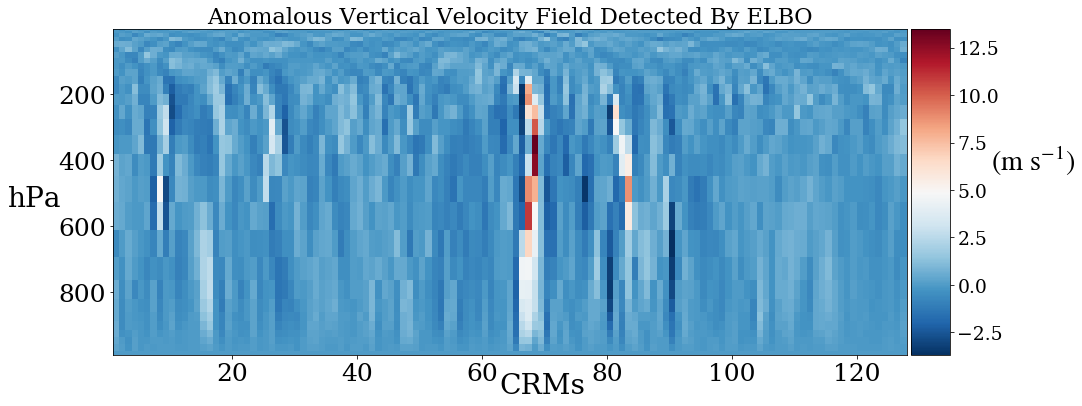

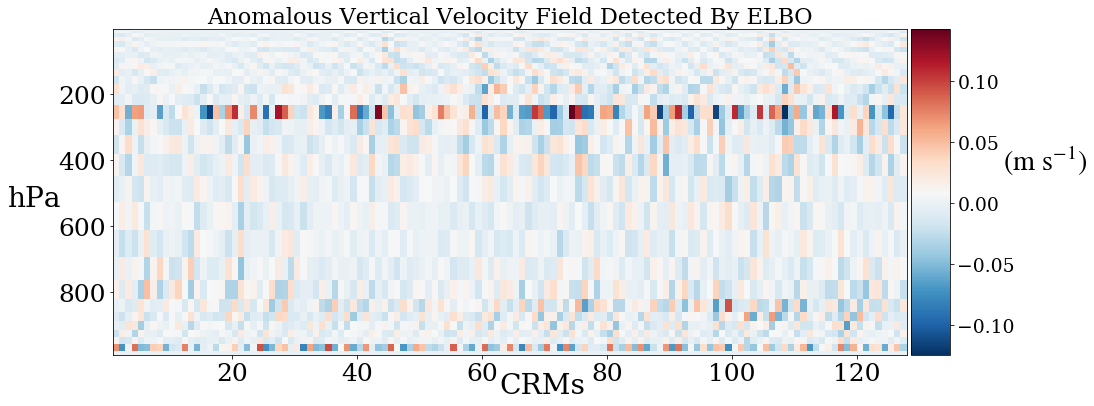

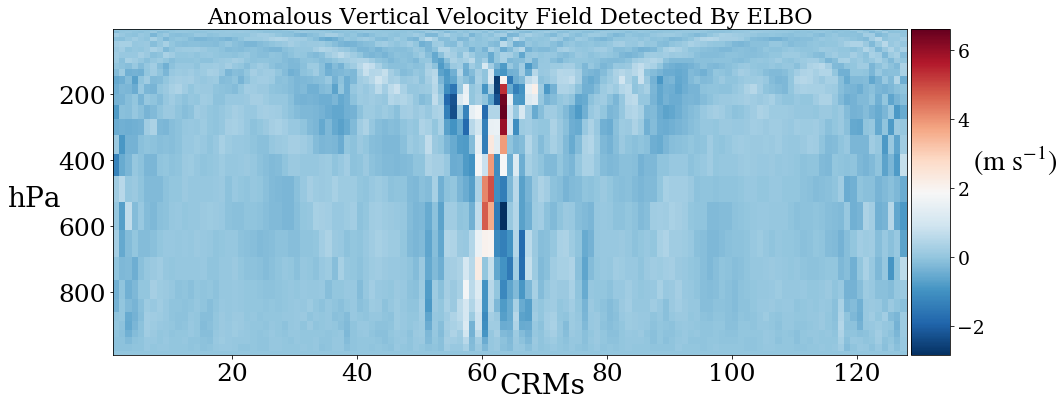

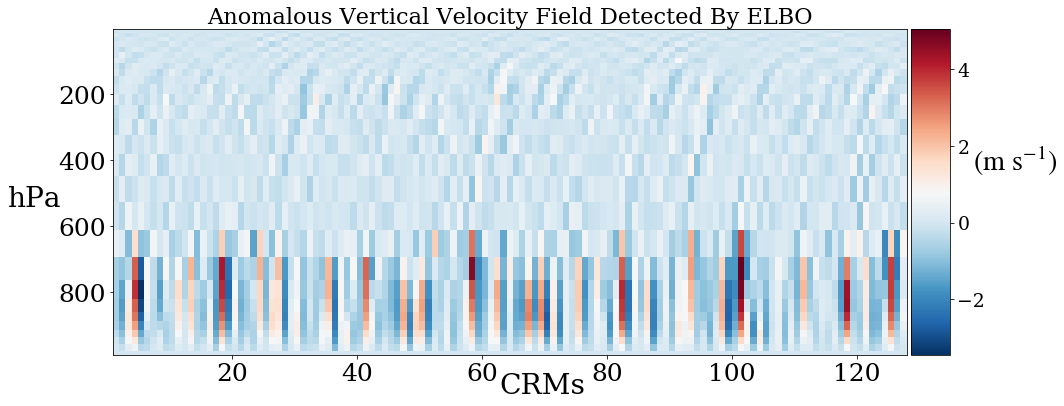

In [49]:
plot_generator_paper(np.squeeze(Test_Images[2425,:,:]),Xs, Zs)
plot_generator_paper(np.squeeze(Test_Images[7803,:,:]),Xs, Zs)
plot_generator_paper(np.squeeze(Test_Images[20826,:,:]),Xs, Zs)
plot_generator_paper(np.squeeze(Test_Images[246,:,:]),Xs, Zs)

In [50]:
temp_test = np.load('/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_W_Test.npy')
Amazon_Max = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_Max_Scalar.npy")
Amazon_Min = np.load("/fast/gmooers/Preprocessed_Data/Centered_50_50/Space_Time_Min_Scalar.npy")
Test_Images = np.interp(temp_test, (0, 1), (Amazon_Min, Amazon_Max))

In [51]:
path = "/DFS-L/DATA/pritchard/gmooers/Workflow/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-20-00000.nc"
extra_variables = xr.open_dataset(path)
ha = extra_variables.hyai.values
hb = extra_variables.hybi.values
PS = 1e5
Pressures_real = PS*ha+PS*hb

fz = 15
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [52]:
interpolated_orig_images = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Interpolation_Data/31_Original_Images_W_Comp_2425_7803.npy")
latent_interpolated_images = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Interpolation_Data/31_Latent_Images_W_Comp_2425_7803.npy")
reconstructed_Image_finals = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Interpolation_Data/31_Reconstructed_Images_W_Comp_2425_7803.npy")
Interpolated_orig_images = np.interp(interpolated_orig_images, (0, 1), (Amazon_Min, Amazon_Max))
Reconstructed_Image_finals = np.interp(reconstructed_Image_finals, (0, 1), (Amazon_Min, Amazon_Max))

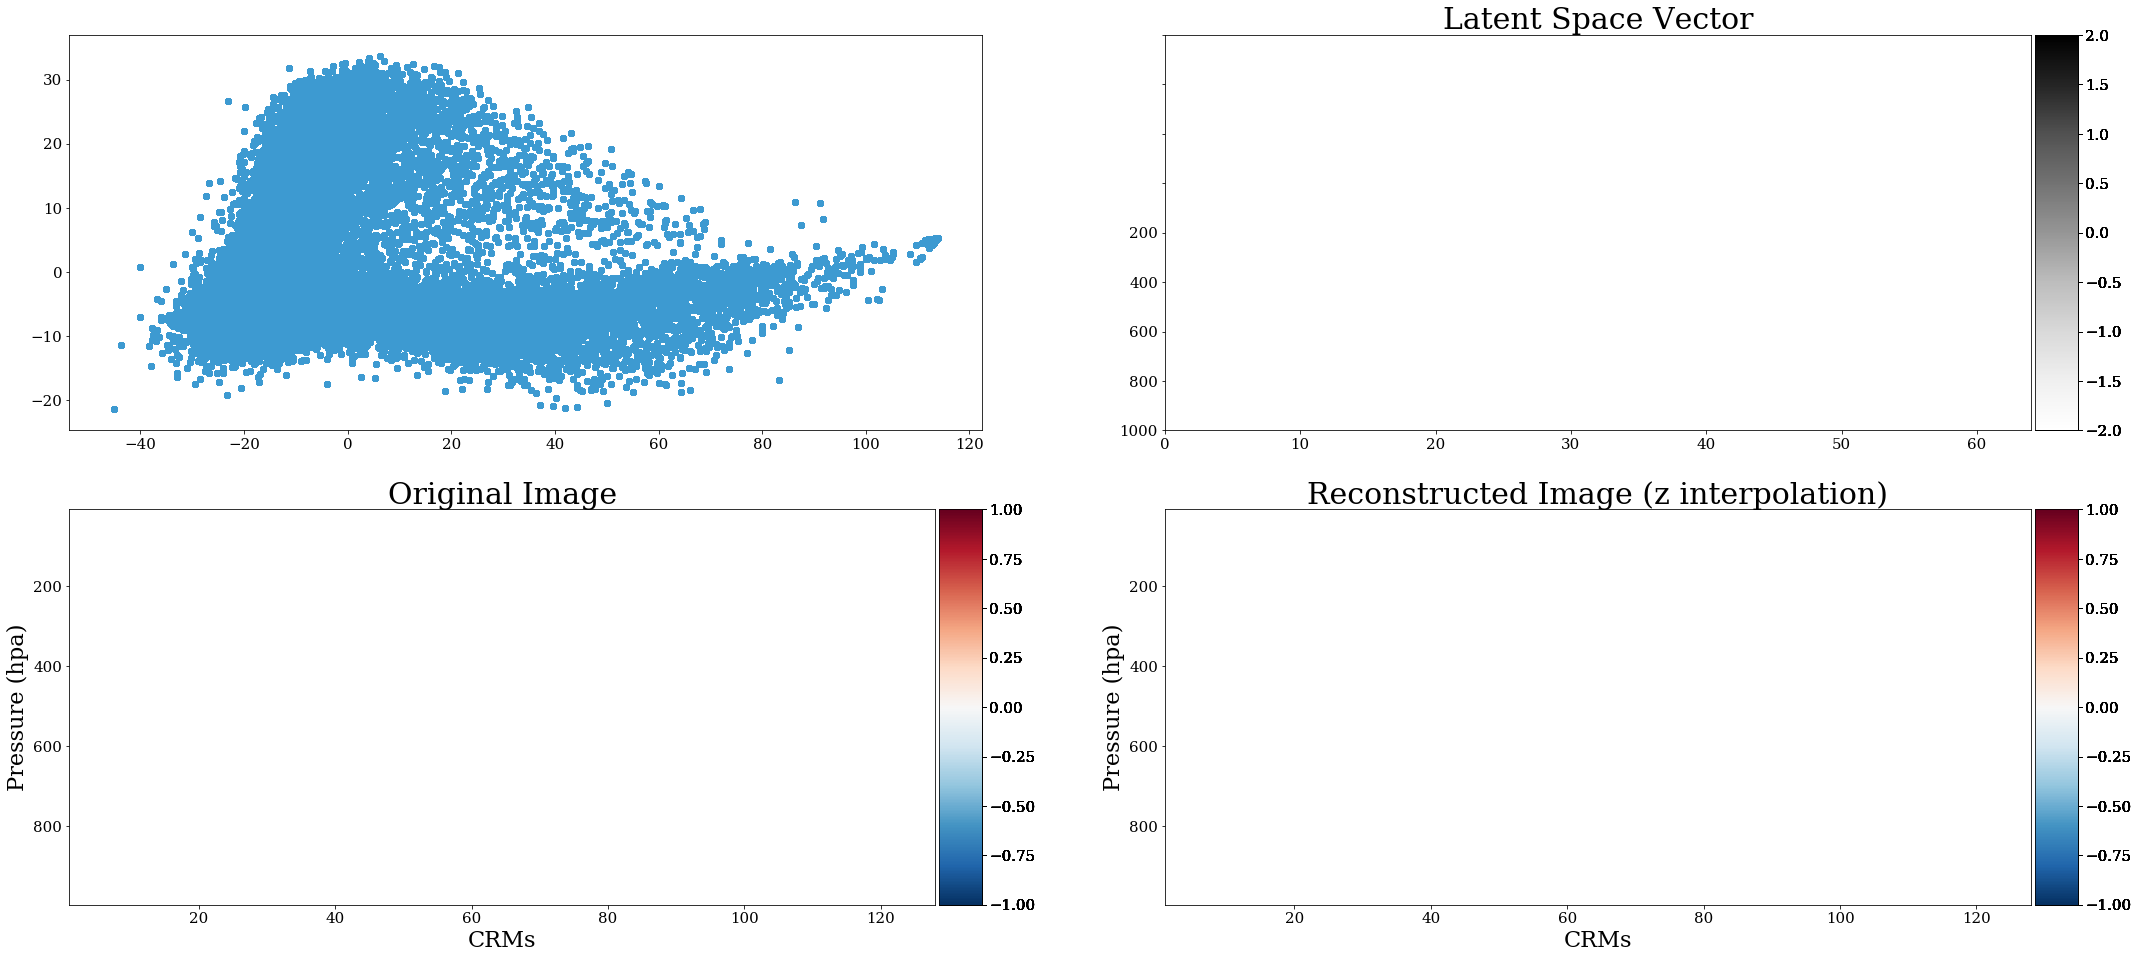

In [53]:
# change vx/vy to location on sorted images
def mikes_horz_latent_animation(h_coords, h_const, latent_space, xdist, ydist, X, Z, hline, o_images, r_images, latents):
    fig, ax = plt.subplots(2,2, figsize=(36,16))
    feat_list = []
    #the real total you need
    o_images = o_images.reshape(len(o_images),30,128)
    r_images = r_images.reshape(len(r_images),30,128)
    latents = latents.reshape(len(latents),16,64)
    num_steps = len(o_images)
    #num_steps = 20
    cmap= "RdBu_r"
    stepsize = np.abs(h_coords[0]- h_coords[-1])/num_steps
    dummy_orginal = np.zeros(shape=(30,128))
    dummy_orginal[:,:] = np.nan
    dummy_recon = np.zeros(shape=(30,128))
    dummy_recon[:,:] = np.nan
    dummy_latent = np.zeros(shape=(16,64))
    dummy_latent[:,:] = np.nan
    count = 29
    count_latent = 7
    for i in range(num_steps):
        
        for j in range(len(dummy_orginal)):
            dummy_orginal[count,:] = o_images[i,j,:]
            dummy_recon[count,:] = r_images[i,j,:]
            count = count-1
        for j in range(len(dummy_latent)):
            dummy_latent[count_latent,:] = latents[i,j,:]
            count_latent = count_latent-1
            
        h_rect = patches.Rectangle((h_coords[0]+stepsize*i,h_const),xdist,ydist,linewidth=4,edgecolor='black',facecolor='none')

        
        y_ticks = np.array([1000, 800, 600, 400, 200])
        
        ax[0,0].scatter(latent_space[:, 0], latent_space[:, 1], c="#3D9AD1",  animated=True)
        #ax[0,0].scatter(x=hline[:, 0], y=hline[:, 1], c="Red", s=2.0,  animated=True)
        cs0 = ax[0,0].add_patch(h_rect)
        
        cs1  = ax[0,1].pcolor(dummy_latent, cmap="Greys", vmin = -2.0, vmax = 2.0, animated=True)
        ax[0,1].set_title("Latent Space Vector", fontsize=fz*2.0)
        ax[0,1].set_yticklabels(y_ticks)
        divider = make_axes_locatable(ax[0,1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(cs1, cax=cax)
        
        
        cs2  = ax[1,0].pcolor(X, Z, dummy_orginal, cmap=cmap, animated=True, vmin = -1.0, vmax = 1.0)
        ax[1,0].set_title("Original Image", fontsize=fz*2.0)
        ax[1,0].set_xlabel("CRMs", fontsize=fz*1.5)
        ax[1,0].set_ylabel("Pressure (hpa)", fontsize=fz*1.5)
        ax[1,0].set_yticklabels(y_ticks)
        divider = make_axes_locatable(ax[1,0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(cs2, cax=cax)
        
        
        cs3 = ax[1,1].pcolor(X, Z, dummy_recon, cmap=cmap, animated=True, vmin = -1.0, vmax = 1.0)
        ax[1,1].set_title("Reconstructed Image (z interpolation)", fontsize=fz*2.0)
        ax[1,1].set_xlabel("CRMs", fontsize=fz*1.5)
        ax[1,1].set_ylabel("Pressure (hpa)", fontsize=fz*1.5)
        ax[1,1].set_yticklabels(y_ticks)
        divider = make_axes_locatable(ax[1,1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(cs3, cax=cax)
        
        
        feat_list.append([cs2, cs3, cs1, cs0])
        

        count = 29 
        count_latent=7
        
    ani = animation.ArtistAnimation(fig, feat_list, interval = 125, blit = False, repeat = True)
    ani.save('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Animations/Figures/Interpolation_Horz_W_31.mp4')
    plt.show()
        
    
mikes_horz_latent_animation(horz_line_latent_sorted[:,0], -8.0, z_test_tsne, 0.2, 1, Xs, Zs, horz_line_latent_sorted, Interpolated_orig_images, Reconstructed_Image_finals, latent_interpolated_images)

In [54]:
vert_interpolated_orig_images = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Interpolation_Data/31_Original_Images_W_Comp_20826_246.npy")
vert_latent_interpolated_images = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Interpolation_Data/31_Latent_Images_W_Comp_20826_246.npy")
vert_reconstructed_Image_finals = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Interpolation_Data/31_Reconstructed_Images_W_Comp_20826_246.npy")
vert_Interpolated_orig_images = np.interp(vert_interpolated_orig_images, (0, 1), (Amazon_Min, Amazon_Max))
vert_Reconstructed_Image_finals = np.interp(vert_reconstructed_Image_finals, (0, 1), (Amazon_Min, Amazon_Max))

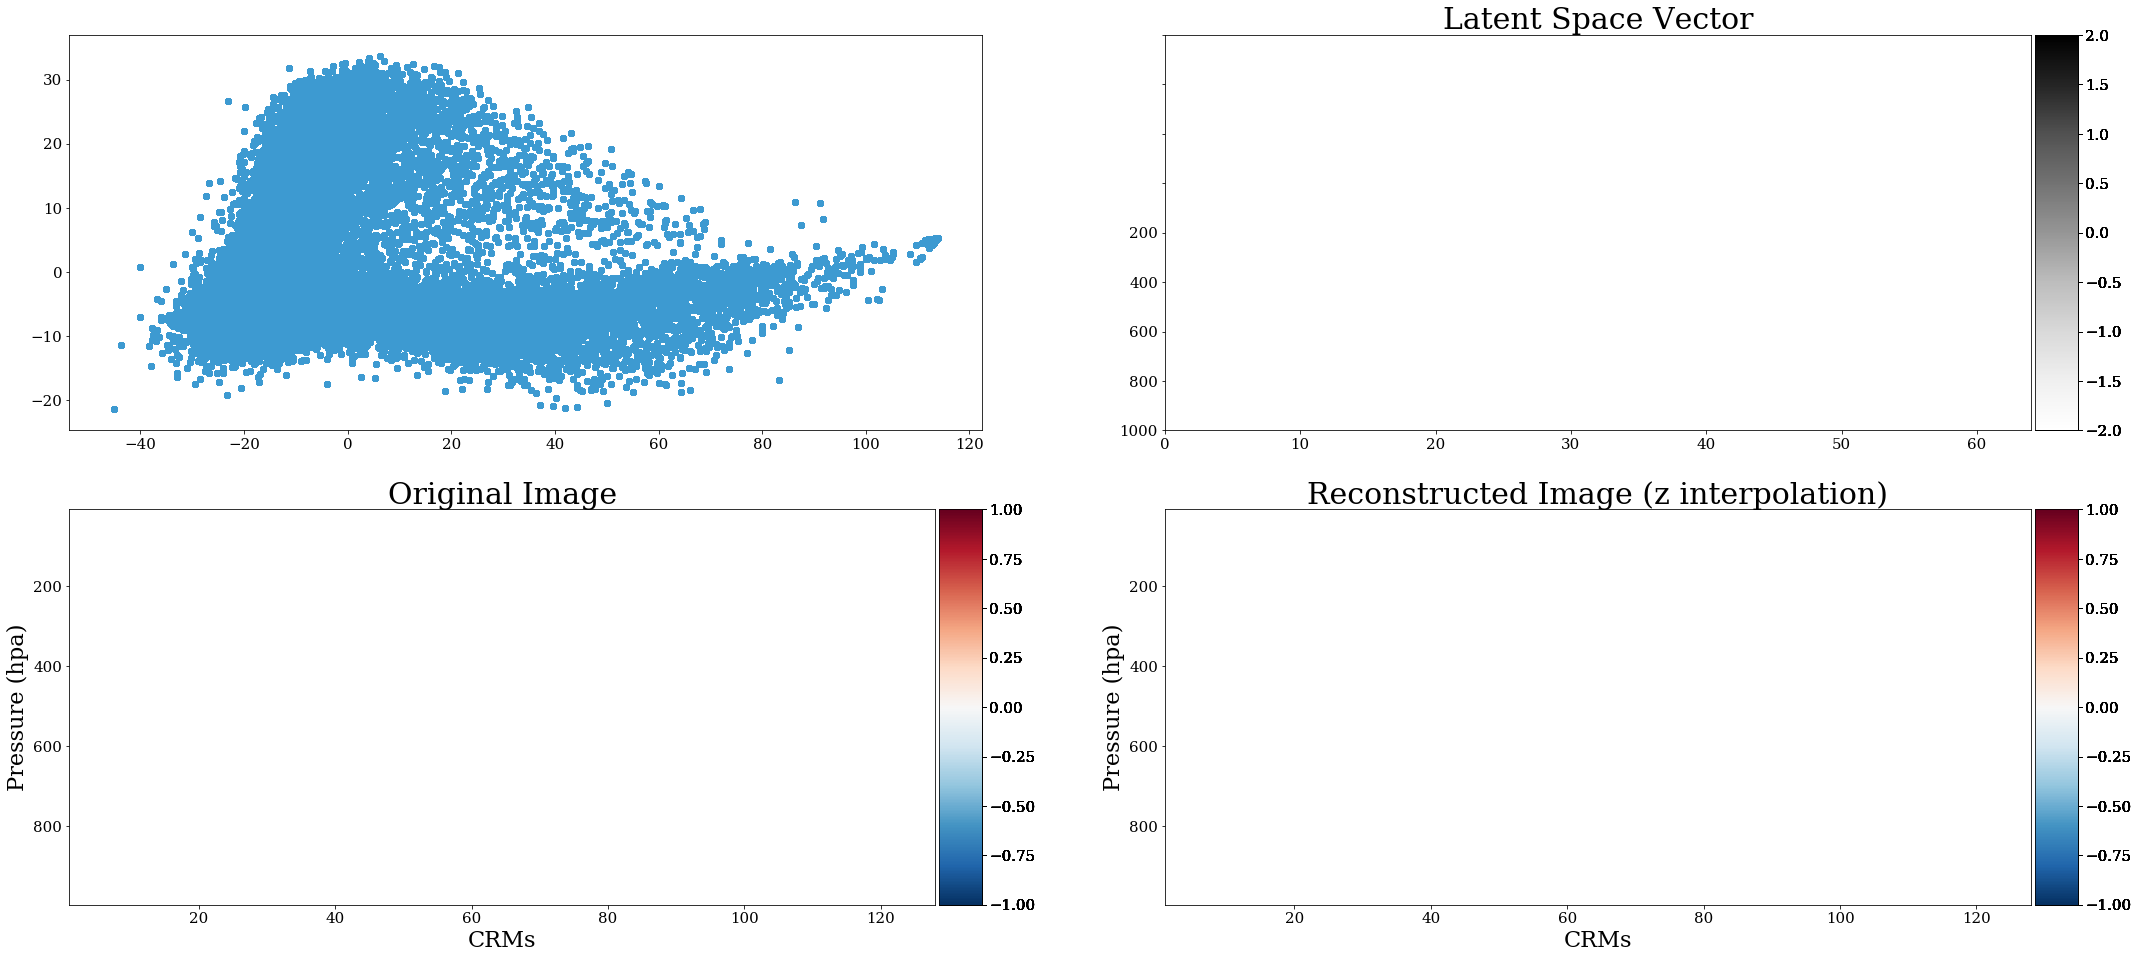

In [55]:
# change vx/vy to location on sorted images
def mikes_vert_latent_animation(v_coords, v_const, latent_space, xdist, ydist, X, Z, vline, o_images, r_images, latents):
    fig, ax = plt.subplots(2,2, figsize=(36,16))
    feat_list = []
    #the real total you need
    o_images = o_images.reshape(len(o_images),30,128)
    r_images = r_images.reshape(len(r_images),30,128)
    latents = latents.reshape(len(latents),16,64)
    num_steps = len(o_images)
    #num_steps = 20
    cmap= "RdBu_r"
    stepsize = np.abs(v_coords[0]- v_coords[-1])/num_steps
    dummy_orginal = np.zeros(shape=(30,128))
    dummy_orginal[:,:] = np.nan
    dummy_recon = np.zeros(shape=(30,128))
    dummy_recon[:,:] = np.nan
    dummy_latent = np.zeros(shape=(16,64))
    dummy_latent[:,:] = np.nan
    count = 29
    count_latent = 7
    for i in range(num_steps):
        
        for j in range(len(dummy_orginal)):
            dummy_orginal[count,:] = o_images[i,j,:]
            dummy_recon[count,:] = r_images[i,j,:]
            count = count-1
        for j in range(len(dummy_latent)):
            dummy_latent[count_latent,:] = latents[i,j,:]
            count_latent = count_latent-1
            
        h_rect = patches.Rectangle((v_const, v_coords[0]+stepsize*i),xdist,ydist,linewidth=4,edgecolor='black',facecolor='none')

        
        y_ticks = np.array([1000, 800, 600, 400, 200])
        
        ax[0,0].scatter(latent_space[:, 0], latent_space[:, 1], c="#3D9AD1",  animated=True)
        #ax[0,0].scatter(x=hline[:, 0], y=hline[:, 1], c="Red", s=2.0,  animated=True)
        cs0 = ax[0,0].add_patch(h_rect)
        
        cs1  = ax[0,1].pcolor(dummy_latent, cmap="Greys", vmin = -2.0, vmax = 2.0, animated=True)
        ax[0,1].set_title("Latent Space Vector", fontsize=fz*2.0)
        ax[0,1].set_yticklabels(y_ticks)
        divider = make_axes_locatable(ax[0,1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(cs1, cax=cax)
        
        
        cs2  = ax[1,0].pcolor(X, Z, dummy_orginal, cmap=cmap, animated=True, vmin = -1.0, vmax = 1.0)
        ax[1,0].set_title("Original Image", fontsize=fz*2.0)
        ax[1,0].set_xlabel("CRMs", fontsize=fz*1.5)
        ax[1,0].set_ylabel("Pressure (hpa)", fontsize=fz*1.5)
        ax[1,0].set_yticklabels(y_ticks)
        divider = make_axes_locatable(ax[1,0])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(cs2, cax=cax)
        
        
        cs3 = ax[1,1].pcolor(X, Z, dummy_recon, cmap=cmap, animated=True, vmin = -1.0, vmax = 1.0)
        ax[1,1].set_title("Reconstructed Image (z interpolation)", fontsize=fz*2.0)
        ax[1,1].set_xlabel("CRMs", fontsize=fz*1.5)
        ax[1,1].set_ylabel("Pressure (hpa)", fontsize=fz*1.5)
        ax[1,1].set_yticklabels(y_ticks)
        divider = make_axes_locatable(ax[1,1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(cs3, cax=cax)
        
        
        feat_list.append([cs2, cs3, cs1, cs0])
        

        count = 29 
        count_latent=7
        
    ani = animation.ArtistAnimation(fig, feat_list, interval = 125, blit = False, repeat = True)
    ani.save('/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/Animations/Figures/Interpolation_Vert_W_31.mp4')
    plt.show()
        
    
mikes_vert_latent_animation(vert_line_latent_sorted[:,1], -12.0, z_test_tsne, 0.2, 1, Xs, Zs, vert_line_latent_sorted, vert_Interpolated_orig_images, vert_Reconstructed_Image_finals, vert_latent_interpolated_images)